<a href="https://colab.research.google.com/github/niruthikka24/DataStorm-3.0/blob/main/DataStorm_SemiFinals_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
import pandas as pd
import numpy as np

from statsmodels.graphics.tsaplots import plot_acf,plot_pacf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from xgboost import XGBRegressor
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
uploaded = files.upload()

Saving promotion_data.csv to promotion_data.csv
Saving test_data.csv to test_data.csv
Saving train_data.csv to train_data.csv
Saving validation_data.csv to validation_data.csv


# Data Preprocessing

In [ ]:
df = pd.read_csv('train_data.csv')
print(df.head())
promo = pd.read_csv('promotion_data.csv')
print(promo.head())

  CategoryCode  ItemCode      DateID  DailySales
0   category_2   1071115  12/19/2021           1
1   category_4    210652   2/13/2022           1
2   category_2    877624  12/19/2021           1
3   category_1    371104  12/19/2021           3
4   category_1   1090294  12/19/2021           3
   ItemCode PromotionStartDate PromotionEndDate  DiscountValue DiscountType  \
0    379249          12/3/2021        12/9/2021             10   Percentage   
1   1066570         11/19/2021       11/25/2021             15   Percentage   
2    124954         10/29/2021        11/4/2021             15   Percentage   
3     35530         10/22/2021       10/28/2021             15   Percentage   
4   1013335          1/21/2022        1/27/2022             10   Percentage   

   SellingPrice  
0            70  
1            45  
2           210  
3            60  
4           210  


In [ ]:
promo[promo['PromotionStartDate'] == '1/4/2022']

,ItemCode,PromotionStartDate,PromotionEndDate,DiscountValue,DiscountType,SellingPrice
25,1081069,1/4/2022,1/13/2022,10,Percentage,45
42,379249,1/4/2022,1/13/2022,10,Percentage,70
89,124954,1/4/2022,1/13/2022,5,Percentage,210
101,1013335,1/4/2022,1/13/2022,10,Percentage,210
107,1101553,1/4/2022,1/13/2022,10,Percentage,150
112,1090240,1/4/2022,1/13/2022,30,Percentage,80
164,872260,1/4/2022,1/13/2022,10,Percentage,320
194,753613,1/4/2022,1/13/2022,10,Percentage,70
206,755584,1/4/2022,1/13/2022,10,Percentage,70
242,1006108,1/4/2022,1/13/2022,30,Percentage,80


In [ ]:
promo.loc[promo['PromotionStartDate'] == '1/4/2022', 'PromotionStartDate'] = '1/7/2022'

In [ ]:
print(promo.shape)
promo = promo.drop_duplicates()
print(promo.shape)

(314, 6)
(314, 6)


In [ ]:
promo.isna().sum()

ItemCode              0
PromotionStartDate    0
PromotionEndDate      0
DiscountValue         0
DiscountType          0
SellingPrice          0
dtype: int64

In [ ]:
df['DateID'] = pd.to_datetime(df['DateID'])
promo['PromotionStartDate'] = pd.to_datetime(promo['PromotionStartDate'])
promo['PromotionEndDate'] = pd.to_datetime(promo['PromotionEndDate'])

In [ ]:
df['Period'] = df['DateID'].dt.to_period('W-THU')
df['Week_Number'] = df['Period'].dt.week
df['startdate'] = df['Period'].dt.start_time.dt.date
df['enddate'] = df['Period'].dt.end_time.dt.date
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Period,Week_Number,startdate,enddate
0,category_2,1071115,2021-12-19,1,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23
1,category_4,210652,2022-02-13,1,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17
2,category_2,877624,2021-12-19,1,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23
3,category_1,371104,2021-12-19,3,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23
4,category_1,1090294,2021-12-19,3,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23


In [ ]:
promo[promo['PromotionStartDate'] + pd.Timedelta(6, unit='d') != promo['PromotionEndDate']]

,ItemCode,PromotionStartDate,PromotionEndDate,DiscountValue,DiscountType,SellingPrice


In [ ]:
df[df['startdate'] + pd.Timedelta(6, unit='d') != df['enddate']]

,CategoryCode,ItemCode,DateID,DailySales,Period,Week_Number,startdate,enddate


In [ ]:
scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
df["Category"] = df["CategoryCode"].replace(scale_mapper)
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Period,Week_Number,startdate,enddate,Category
0,category_2,1071115,2021-12-19,1,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2
1,category_4,210652,2022-02-13,1,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,4
2,category_2,877624,2021-12-19,1,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2
3,category_1,371104,2021-12-19,3,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1
4,category_1,1090294,2021-12-19,3,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1


In [ ]:
df['WeeklySales']  = df.groupby(['Category','ItemCode','Week_Number'])['DailySales'].transform('sum')
df.head()

,CategoryCode,ItemCode,DateID,DailySales,Period,Week_Number,startdate,enddate,Category,WeeklySales
0,category_2,1071115,2021-12-19,1,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2,2
1,category_4,210652,2022-02-13,1,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,4,8
2,category_2,877624,2021-12-19,1,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2,32
3,category_1,371104,2021-12-19,3,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,11
4,category_1,1090294,2021-12-19,3,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,14


In [ ]:
df1 = df.drop(['DailySales','DateID','CategoryCode'],axis=1)
df1.head()

,ItemCode,Period,Week_Number,startdate,enddate,Category,WeeklySales
0,1071115,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2,2
1,210652,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,4,8
2,877624,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2,32
3,371104,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,11
4,1090294,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,14


In [ ]:
print(df1.shape)
df1 = df1.drop_duplicates()
print(df1.shape)

(20651, 7)
(3833, 7)


In [ ]:
df2 = df1.copy(deep=True)

In [ ]:
print(df2.ItemCode.nunique())
print(promo.ItemCode.nunique())

197
66


In [ ]:
df2['OnPromo'] = 0
df2['OriginalSellingPrice'] = 0
df2['SellingPrice'] = 0
for item in list(promo.ItemCode.unique()):
  promosub = promo[promo['ItemCode'] == item]
  for index, row in promosub.iterrows():
    startdate = row['PromotionStartDate']
    enddate = row['PromotionEndDate']
    distype = row['DiscountType']
    disval = row['DiscountValue']
    price = row['SellingPrice']
    sellingprice = 0
    if distype == 'Amount':
      sellingprice = price - disval
    elif distype == 'Percentage':
      sellingprice = price - price*disval/100
    df2.loc[(df2['ItemCode'] == item ) & (df2['enddate'] == enddate) & (df2['startdate'] == startdate), 'OnPromo'] = 1
    df2.loc[(df2['ItemCode'] == item ) & (df2['enddate'] == enddate) & (df2['startdate'] == startdate), 'OriginalSellingPrice'] = price
    df2.loc[(df2['ItemCode'] == item ) & (df2['enddate'] == enddate) & (df2['startdate'] == startdate), 'SellingPrice'] = sellingprice
    

/usr/local/lib/python3.7/dist-packages/pandas/core/ops/array_ops.py:73: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  result = libops.scalar_compare(x.ravel(), y, op)


In [ ]:
sub0 = df2[df2['OnPromo']==0]
sub0['OriginalSellingPrice'].value_counts()

0    3565
Name: OriginalSellingPrice, dtype: int64

In [ ]:
sub0['SellingPrice'].value_counts()

0.0    3565
Name: SellingPrice, dtype: int64

In [ ]:
sub1 = df2[df2['OnPromo']==1]
sub1.shape

(268, 10)

In [ ]:
sub1[sub1['OriginalSellingPrice'] == 0]

,ItemCode,Period,Week_Number,startdate,enddate,Category,WeeklySales,OnPromo,OriginalSellingPrice,SellingPrice


In [ ]:
promo[promo['ItemCode'] == 7666]

In [ ]:
df2.head()

,ItemCode,Period,Week_Number,startdate,enddate,Category,WeeklySales,OnPromo,OriginalSellingPrice,SellingPrice
0,1071115,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2,2,0,0,0.0
1,210652,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,4,8,0,0,0.0
2,877624,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,2,32,0,0,0.0
3,371104,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,11,0,0,0.0
4,1090294,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,14,0,0,0.0


In [ ]:
mini = df2[df2['ItemCode'] == 17287]
mini = mini.sort_values(['startdate'])
mini

In [ ]:
df2.to_csv('preprocessed_sellingprice.csv',index=False) 
files.download('preprocessed_sellingprice.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
df2.to_csv('preprocessed_train.csv',index=False) 
files.download('preprocessed_train.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Model Training

In [ ]:
df2[df2['OnPromo'] == 1].shape

(268, 10)

In [ ]:
df2[df2['OnPromo'] == 0].shape

(3565, 10)

Model Training for Items on Promotion

In [ ]:
dfpromo = df2[df2['OnPromo'] == 1]
dfpromo.head()

,ItemCode,Period,Week_Number,startdate,enddate,Category,WeeklySales,OnPromo,OriginalSellingPrice,SellingPrice
13,130993,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,66,1,70,63.0
21,379249,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,108,1,70,63.0
22,124954,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,34,1,210,189.0
25,1101571,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,29,1,140,126.0
34,1085749,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,17,1,70,63.0


In [ ]:
dfcor = dfpromo[['ItemCode','Week_Number','Category','OriginalSellingPrice','SellingPrice','WeeklySales']]

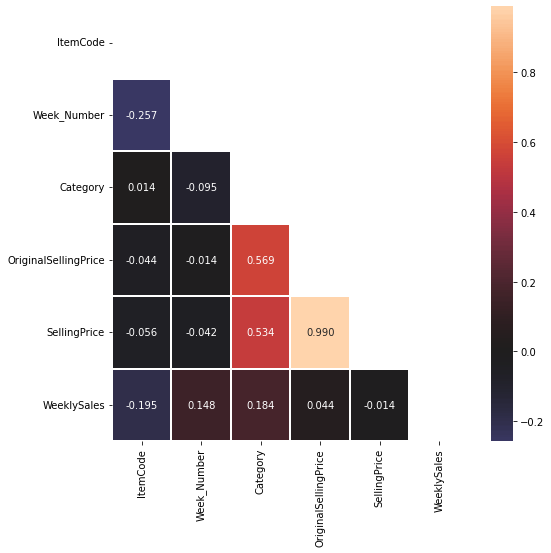

In [ ]:
corr=dfcor.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(corr, mask=mask,  center=0, linewidths=1, annot=True, fmt=".3f", ax = ax)
plt.show()

In [ ]:
xtrain = dfpromo[['ItemCode','Week_Number','Category','OriginalSellingPrice','SellingPrice']]
ytrain = dfpromo['WeeklySales']
xtrain.head()

,ItemCode,Week_Number,Category,OriginalSellingPrice,SellingPrice
13,130993,7,2,70,63.0
21,379249,51,1,70,63.0
22,124954,7,2,210,189.0
25,1101571,7,2,140,126.0
34,1085749,51,1,70,63.0


In [ ]:
rf = RandomForestRegressor(n_estimators = 15, random_state = 0)
rf.fit(xtrain, ytrain)
rf.feature_importances_

array([0.2702711 , 0.08819656, 0.12927882, 0.08495667, 0.42729685])

In [ ]:
#outlier replaced
rf = RandomForestRegressor(n_estimators = 15, random_state = 0)
rf.fit(xtrain, ytrain)
rf.feature_importances_

array([0.25409817, 0.1889682 , 0.12600398, 0.14036895, 0.2905607 ])

<BarContainer object of 5 artists>

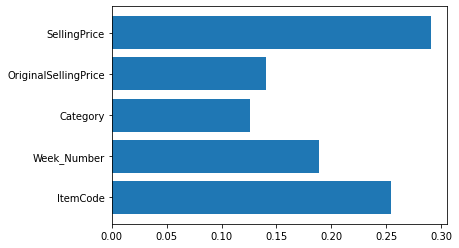

In [ ]:
#after outlier removal replacement
plt.barh(xtrain.columns, rf.feature_importances_)

<BarContainer object of 5 artists>

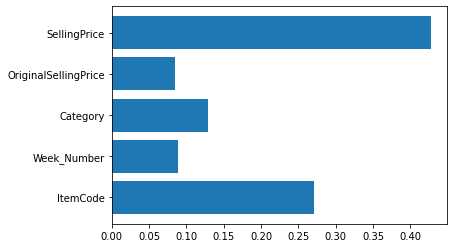

In [ ]:
plt.barh(xtrain.columns, rf.feature_importances_)

In [ ]:
validation = pd.read_csv('validation_data.csv')
validation.head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales
0,category_2,1006090,w1,0,9
1,category_2,1105009,w1,0,15
2,category_2,1098502,w3,0,7
3,category_1,1081321,w3,0,25
4,category_4,1074823,w1,0,24


In [ ]:
promo.shape

(314, 6)

In [ ]:
def preprocessvalidation(df,promo):
  scale_mapper = {"category_1":1, "category_2":2, "category_3":3,"category_4":4}
  df["Category"] = df["CategoryCode"].replace(scale_mapper)
  scale_mapper1 = {"w1":'2022-02-18', "w2":'2022-02-25', "w3":'2022-03-04',"w4":'2022-03-11'}
  df["startdate"] = df["Week"].replace(scale_mapper1)
  scale_mapper2 = {"w1":'2022-02-24', "w2":'2022-03-03', "w3":'2022-03-10',"w4":'2022-03-17'}
  df["enddate"] = df["Week"].replace(scale_mapper2)
  scale_mapper3 = {"w1":8, "w2":9, "w3":10,"w4":11}
  df["Week_Number"] = df["Week"].replace(scale_mapper3)
  df['startdate'] = pd.to_datetime(df['startdate'])
  df['enddate'] = pd.to_datetime(df['enddate'])
  df['OriginalSellingPrice'] = 0
  df['SellingPrice'] = 0
  dfsub = df[df['OnPromo'] == 1]
  for item in list(dfsub.ItemCode.unique()):
    promosub = promo[promo['ItemCode'] == item]
    for index, row in promosub.iterrows():
      startdate = row['PromotionStartDate']
      enddate = row['PromotionEndDate']
      distype = row['DiscountType']
      disval = row['DiscountValue']
      price = row['SellingPrice']
      sellingprice = 0
      if distype == 'Amount':
        sellingprice = price - disval
      elif distype == 'Percentage':
        sellingprice = price - price*disval/100
      df.loc[(df['ItemCode'] == item ) & (df['enddate'] == enddate) & (df['startdate'] == startdate), 'OnPromo'] = 1
      df.loc[(df['ItemCode'] == item ) & (df['enddate'] == enddate) & (df['startdate'] == startdate), 'OriginalSellingPrice'] = price
      df.loc[(df['ItemCode'] == item ) & (df['enddate'] == enddate) & (df['startdate'] == startdate), 'SellingPrice'] = sellingprice
    
    

In [ ]:
preprocessvalidation(validation,promo)


In [ ]:
validation[validation['OnPromo']==1].shape

(22, 11)

In [ ]:
df2.shape

(3833, 10)

In [ ]:
validpromo = validation[validation['OnPromo']==1]

In [ ]:
validpromo.head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice
60,category_2,30877,w2,1,121,2,2022-02-25,2022-03-03,9,70,63.00
64,category_2,1090258,w3,1,61,2,2022-03-04,2022-03-10,10,140,126.00
75,category_3,1066570,w2,1,124,3,2022-02-25,2022-03-03,9,45,38.25
81,category_1,1085749,w1,1,17,1,2022-02-18,2022-02-24,8,70,63.00
82,category_2,50785,w3,1,72,2,2022-03-04,2022-03-10,10,65,58.50


In [ ]:
validpromox = validpromo[['ItemCode','Week_Number','Category','OriginalSellingPrice','SellingPrice']]
validpromoy = validpromo['WeeklySales']
validpromox.head()

,ItemCode,Week_Number,Category,OriginalSellingPrice,SellingPrice
60,30877,9,2,70,63.00
64,1090258,10,2,140,126.00
75,1066570,9,3,45,38.25
81,1085749,8,1,70,63.00
82,50785,10,2,65,58.50


In [ ]:
pred = rf.predict(validpromox)

In [ ]:
validpromo['PredictedSales'] = pred
validpromo.head()

In [ ]:
def totalmape(Y_actual,Y_Predicted):
    totalmape = np.sum(np.abs(Y_actual - Y_Predicted))/np.sum(Y_actual)
    return totalmape

In [ ]:
LR_MAPE= totalmape(validpromoy, pred)
print("MAPE: ",LR_MAPE)

MAPE:  0.7293540945790082


In [ ]:
#outlier handled
LR_MAPE= totalmape(validpromoy, pred)
print("MAPE: ",LR_MAPE)

MAPE:  0.45732410611303353


In [ ]:
#outlier handled
xtrain2 = xtrain.drop(['Category','OriginalSellingPrice'],axis=1)
# xtrain2.head()
validpromox2 = validpromo[['ItemCode','Week_Number','SellingPrice']]

In [ ]:
#outlier handled
rf1 = RandomForestRegressor(n_estimators = 15, random_state = 0)
rf1.fit(xtrain2, ytrain)
pred1 = rf1.predict(validpromox2)
LR_MAPE= totalmape(validpromoy, pred1)
print("MAPE: ",LR_MAPE)

MAPE:  0.5044405997693194


In [ ]:
#outlier handled
for val in [5,10,20,50,100,200, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
  rf1 = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf1.fit(xtrain, ytrain)
  pred1 = rf1.predict(validpromox)
  LR_MAPE= totalmape(validpromoy, pred1)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  5
MAPE:  0.4519031141868513
n_estimators:  10
MAPE:  0.4521626297577855
n_estimators:  20
MAPE:  0.4648788927335641
n_estimators:  50
MAPE:  0.4406228373702422
n_estimators:  100
MAPE:  0.42529411764705877
n_estimators:  200
MAPE:  0.4201254325259516
n_estimators:  400
MAPE:  0.4252465397923875
n_estimators:  500
MAPE:  0.4192629757785468
n_estimators:  600
MAPE:  0.4204700115340253
n_estimators:  800
MAPE:  0.4195685553633218
n_estimators:  1000
MAPE:  0.42223183391003455
n_estimators:  1200
MAPE:  0.42337874855824686
n_estimators:  1400
MAPE:  0.42326804251112216
n_estimators:  1600
MAPE:  0.42597210207612457
n_estimators:  1800
MAPE:  0.42665993848519795
n_estimators:  2000
MAPE:  0.4250787197231834


In [ ]:
#outlier handled
for val in [5,10,20,50,100,200, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
  rf1 = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf1.fit(xtrain2, ytrain)
  pred1 = rf1.predict(validpromox2)
  LR_MAPE= totalmape(validpromoy, pred1)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  5
MAPE:  0.554152249134948
n_estimators:  10
MAPE:  0.5291522491349481
n_estimators:  20
MAPE:  0.5108564013840831
n_estimators:  50
MAPE:  0.4615397923875432
n_estimators:  100
MAPE:  0.43171280276816604
n_estimators:  200
MAPE:  0.44407439446366775
n_estimators:  400
MAPE:  0.44520112456747407
n_estimators:  500
MAPE:  0.44117993079584766
n_estimators:  600
MAPE:  0.4420818915801614
n_estimators:  800
MAPE:  0.4414987024221454
n_estimators:  1000
MAPE:  0.44118512110726643
n_estimators:  1200
MAPE:  0.44386317762399075
n_estimators:  1400
MAPE:  0.44232266435986156
n_estimators:  1600
MAPE:  0.44507947664359865
n_estimators:  1800
MAPE:  0.44653210303729324
n_estimators:  2000
MAPE:  0.44544463667820067


In [ ]:
xtrain1 = xtrain.drop(['Week_Number','OriginalSellingPrice'],axis=1)
xtrain1.head()

,ItemCode,Category,SellingPrice
13,130993,2,63.0
21,379249,1,63.0
22,124954,2,189.0
25,1101571,2,126.0
34,1085749,1,63.0


In [ ]:
validpromox1 = validpromo[['ItemCode','Category','SellingPrice']]
validpromox1.head()

,ItemCode,Category,SellingPrice
60,30877,2,63.00
64,1090258,2,126.00
75,1066570,3,38.25
81,1085749,1,63.00
82,50785,2,58.50


In [ ]:
rf1 = RandomForestRegressor(n_estimators = 15, random_state = 0)
rf1.fit(xtrain1, ytrain)
pred1 = rf1.predict(validpromox1)
LR_MAPE= totalmape(validpromoy, pred1)
print("MAPE: ",LR_MAPE)

MAPE:  0.6758974659369021


In [ ]:
for val in [5,10,20,50,100]:
  rf1 = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf1.fit(xtrain1, ytrain)
  pred1 = rf1.predict(validpromox1)
  LR_MAPE= totalmape(validpromoy, pred1)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  5
MAPE:  0.931296542989882
n_estimators:  10
MAPE:  0.8062050381135588
n_estimators:  20
MAPE:  0.5911546339910453
n_estimators:  50
MAPE:  0.47141319702760637
n_estimators:  100
MAPE:  0.3992623800600946


In [ ]:
for val in [200, 400, 500, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]:
  rf1 = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf1.fit(xtrain1, ytrain)
  pred1 = rf1.predict(validpromox1)
  LR_MAPE= totalmape(validpromoy, pred1)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  200
MAPE:  0.37985705685365023
n_estimators:  400
MAPE:  0.3762865777016846
n_estimators:  500
MAPE:  0.3704902404101899
n_estimators:  600
MAPE:  0.3697948651353377
n_estimators:  800
MAPE:  0.36495038695069254
n_estimators:  1000
MAPE:  0.3590065542879485
n_estimators:  1200
MAPE:  0.35289814961019605
n_estimators:  1400
MAPE:  0.3526762155595663
n_estimators:  1600
MAPE:  0.3527921241384643
n_estimators:  1800
MAPE:  0.35242089225772527
n_estimators:  2000
MAPE:  0.35049732236304265


In [ ]:
for val in [1300, 1350, 1375, 1400, 1450, 1500]:
  rf1 = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf1.fit(xtrain1, ytrain)
  pred1 = rf1.predict(validpromox1)
  LR_MAPE= totalmape(validpromoy, pred1)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  1300
MAPE:  0.3530247901424277
n_estimators:  1350
MAPE:  0.3531288286502523
n_estimators:  1375
MAPE:  0.35252020119896765
n_estimators:  1400
MAPE:  0.3526762155595663
n_estimators:  1450
MAPE:  0.3529109739922893
n_estimators:  1500
MAPE:  0.3534430380557561


In [ ]:
for val in [1370, 1380, 1385, 1390, 1395]:
  rf1 = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf1.fit(xtrain1, ytrain)
  pred1 = rf1.predict(validpromox1)
  LR_MAPE= mape(validpromoy, pred1)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  1370
MAPE:  54.256237364613156
n_estimators:  1380
MAPE:  54.26699788937138
n_estimators:  1385
MAPE:  54.23834399610807
n_estimators:  1390
MAPE:  54.205809346175435
n_estimators:  1395
MAPE:  54.22121090250664


In [ ]:
mape_scorer = make_scorer(totalmape)

In [ ]:
for val in [1000,1200,1500,1750,2000]:
  model = RandomForestRegressor(n_estimators = val, random_state = 0)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_val_score(model, xtrain1, ytrain, scoring=mape_scorer, cv=cv, n_jobs=-1)
  print("n_estimator: ", val)
  print(np.mean(np.absolute(scores)))
  print("=======================================")

n_estimator:  1000
0.4010068197390854
n_estimator:  1200
0.4014039716442489
n_estimator:  1500
0.4021097653202178
n_estimator:  1750
0.40224340439408535
n_estimator:  2000
0.4022166209059824


In [ ]:
xtrain2 = xtrain.drop(['Week_Number','OriginalSellingPrice','Category'],axis=1)
validpromox2 = validpromo[['ItemCode','SellingPrice']]
rf2 = RandomForestRegressor(n_estimators = 15, random_state = 0)
rf2.fit(xtrain2, ytrain)
pred2 = rf2.predict(validpromox2)
LR_MAPE= mape(validpromoy, pred2)
print("MAPE: ",LR_MAPE)

MAPE:  76.3848820815885


Model Training for Items that are not on Promotion

In [ ]:
dfnonpromo = df2[df2['OnPromo'] == 0]
print(dfnonpromo.head())
print(dfnonpromo.shape)

   ItemCode                 Period  Week_Number   startdate     enddate  \
0   1071115  2021-12-17/2021-12-23           51  2021-12-17  2021-12-23   
1    210652  2022-02-11/2022-02-17            7  2022-02-11  2022-02-17   
2    877624  2021-12-17/2021-12-23           51  2021-12-17  2021-12-23   
3    371104  2021-12-17/2021-12-23           51  2021-12-17  2021-12-23   
4   1090294  2021-12-17/2021-12-23           51  2021-12-17  2021-12-23   

   Category  WeeklySales  OnPromo  OriginalSellingPrice  SellingPrice  
0         2            2        0                     0           0.0  
1         4            8        0                     0           0.0  
2         2           32        0                     0           0.0  
3         1           11        0                     0           0.0  
4         1           14        0                     0           0.0  
(3565, 10)


In [ ]:
validnonpromo = validation[validation['OnPromo']==0]
print(validnonpromo.head())
print(validnonpromo.shape)

  CategoryCode  ItemCode Week  OnPromo  WeeklySales  Category  startdate  \
0   category_2   1006090   w1        0            9         2 2022-02-18   
1   category_2   1105009   w1        0           15         2 2022-02-18   
2   category_2   1098502   w3        0            7         2 2022-03-04   
3   category_1   1081321   w3        0           25         1 2022-03-04   
4   category_4   1074823   w1        0           24         4 2022-02-18   

     enddate  Week_Number  OriginalSellingPrice  SellingPrice  
0 2022-02-24            8                     0           0.0  
1 2022-02-24            8                     0           0.0  
2 2022-03-10           10                     0           0.0  
3 2022-03-10           10                     0           0.0  
4 2022-02-24            8                     0           0.0  
(351, 11)


In [ ]:
dfnonpromox = dfnonpromo[['ItemCode','Week_Number','Category']]
dfnonpromoy = dfnonpromo['WeeklySales']
print(dfnonpromox.head())
validnonpromox = validnonpromo[['ItemCode','Week_Number','Category']]
validnonpromoy = validnonpromo['WeeklySales']
print(validnonpromox.head())

   ItemCode  Week_Number  Category
0   1071115           51         2
1    210652            7         4
2    877624           51         2
3    371104           51         1
4   1090294           51         1
   ItemCode  Week_Number  Category
0   1006090            8         2
1   1105009            8         2
2   1098502           10         2
3   1081321           10         1
4   1074823            8         4


In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [50,100, 150, 200,]# 300, 1000
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(dfnonpromox, dfnonpromoy)
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters: {'bootstrap': True, 'max_depth': 80, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 200}


In [ ]:
#using the best parameters found above
rf = RandomForestRegressor(n_estimators = 200,max_depth=80,min_samples_leaf=3,min_samples_split=8,random_state = 0)
rf.fit(dfnonpromox, dfnonpromoy)
pred = rf.predict(validnonpromox)
LR_MAPE= totalmape(validnonpromoy, pred)
print("n_estimators: ",val)
print("MAPE: ",LR_MAPE)
print("================================")

n_estimators:  2000
MAPE:  0.3790463980721204


In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [300,500,750,1000]# 300, 1000
}
rf = RandomForestRegressor()
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(dfnonpromox, dfnonpromoy)
print("Best parameters:", grid_search.best_params_)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best parameters: {'bootstrap': True, 'max_depth': 90, 'min_samples_leaf': 3, 'min_samples_split': 8, 'n_estimators': 300}


In [ ]:
#using the best parameters found above
rf = RandomForestRegressor(n_estimators = 300,max_depth=90,min_samples_leaf=3,min_samples_split=8,random_state = 0)
rf.fit(dfnonpromox, dfnonpromoy)
pred = rf.predict(validnonpromox)
LR_MAPE= totalmape(validnonpromoy, pred)
print("n_estimators: ",val)
print("MAPE: ",LR_MAPE)
print("================================")

n_estimators:  2000
MAPE:  0.37647635239140065


In [ ]:
for val in [5,10,20,50,100,200,250,500,750,1000,1250,1500,1750,2000]:
  rf = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf.fit(dfnonpromox, dfnonpromoy)
  pred = rf.predict(validnonpromox)
  LR_MAPE= totalmape(validnonpromoy, pred)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  5
MAPE:  0.40465116279069757
n_estimators:  10
MAPE:  0.40653972217886686
n_estimators:  20
MAPE:  0.3995707819572343
n_estimators:  50
MAPE:  0.40250871442692887
n_estimators:  100
MAPE:  0.39946516830549916
n_estimators:  200
MAPE:  0.4002234535143853
n_estimators:  250
MAPE:  0.3989494823370272
n_estimators:  500
MAPE:  0.3992943135112637
n_estimators:  750
MAPE:  0.39978814837937676
n_estimators:  1000
MAPE:  0.4004423807294106
n_estimators:  1250
MAPE:  0.40068316945008065
n_estimators:  1500
MAPE:  0.401326951424657
n_estimators:  1750
MAPE:  0.40111996551390966
n_estimators:  2000
MAPE:  0.4005852453046147


In [ ]:
for val in [25,30,35,40,45]: #80, 90, 100, 120, 125, 150
  rf = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf.fit(dfnonpromox, dfnonpromoy)
  pred = rf.predict(validnonpromox)
  LR_MAPE= totalmape(validnonpromoy, pred)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  25
MAPE:  0.403852036834712
n_estimators:  30
MAPE:  0.40835197613721097
n_estimators:  35
MAPE:  0.4071959984243424
n_estimators:  40
MAPE:  0.40338171791269967
n_estimators:  45
MAPE:  0.4041262739249316


In [ ]:
for val in [60,65,70,75,85]:
  rf = RandomForestRegressor(n_estimators = val, random_state = 0)
  rf.fit(dfnonpromox, dfnonpromoy)
  pred = rf.predict(validnonpromox)
  LR_MAPE= mape(validnonpromoy, pred)
  print("n_estimators: ",val)
  print("MAPE: ",LR_MAPE)
  print("================================")

n_estimators:  60
MAPE:  73.43863636002224
n_estimators:  65
MAPE:  73.37898187496897
n_estimators:  70
MAPE:  72.69826261345086
n_estimators:  75
MAPE:  72.90361270292487
n_estimators:  85
MAPE:  73.39403540547677


In [ ]:
for val in [20,50,75,100]:#60,65,70,75,80,85
  model = RandomForestRegressor(n_estimators = val, random_state = 0)
  cv = KFold(n_splits=10, random_state=1, shuffle=True)
  scores = cross_val_score(model, dfnonpromox, dfnonpromoy, scoring=mape_scorer, cv=cv, n_jobs=-1)
  print("n_estimator: ", val)
  print(np.mean(np.absolute(scores)))
  print("=======================================")

n_estimator:  20
0.3241404236656501
n_estimator:  50
0.3236534596849848
n_estimator:  75
0.32251281545136334
n_estimator:  100
0.32214016072737045


In [ ]:
validation.head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice
0,category_2,1006090,w1,0,9,2,2022-02-18,2022-02-24,8,0,0.0
1,category_2,1105009,w1,0,15,2,2022-02-18,2022-02-24,8,0,0.0
2,category_2,1098502,w3,0,7,2,2022-03-04,2022-03-10,10,0,0.0
3,category_1,1081321,w3,0,25,1,2022-03-04,2022-03-10,10,0,0.0
4,category_4,1074823,w1,0,24,4,2022-02-18,2022-02-24,8,0,0.0


In [ ]:
validation['PredictedSales'] = 0
validation.shape

(373, 12)

In [ ]:
validnonpromox.shape

(351, 3)

In [ ]:
validpromox1.shape

(22, 3)

In [ ]:
rfnp = RandomForestRegressor(n_estimators = 300,max_depth=90,min_samples_leaf=3,min_samples_split=8,random_state = 0) #n_estimators = 100, random_state = 0
rfnp.fit(dfnonpromox, dfnonpromoy)
prednp = rfnp.predict(validnonpromox)

In [ ]:
validnonpromo['PredictedSales'] = prednp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
validnonpromo.head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales
0,category_2,1006090,w1,0,9,2,2022-02-18,2022-02-24,8,0,0.0,12.908178
1,category_2,1105009,w1,0,15,2,2022-02-18,2022-02-24,8,0,0.0,7.202554
2,category_2,1098502,w3,0,7,2,2022-03-04,2022-03-10,10,0,0.0,5.880728
3,category_1,1081321,w3,0,25,1,2022-03-04,2022-03-10,10,0,0.0,18.511750
4,category_4,1074823,w1,0,24,4,2022-02-18,2022-02-24,8,0,0.0,56.871159


In [ ]:
validnonpromo.to_csv('validnonpromopred.csv',index=False) 
files.download('validnonpromopred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
validation['PredictedSales1'] = 0

In [ ]:
def fillSales(validation,validnonpromo,promoval):
  for item in list(validnonpromo.ItemCode.unique()):
    dfsub = validnonpromo[validnonpromo['ItemCode'] == item]
    for index, row in dfsub.iterrows():
        startdate = row['startdate']
        enddate = row['enddate']
        sales = row['PredictedSales']
        validation.loc[(validation['ItemCode'] == item ) & (validation['enddate'] == enddate) & (validation['startdate'] == startdate) & (validation['OnPromo'] == promoval), 'PredictedSales1'] = sales

In [ ]:
fillSales(validation,validnonpromo,0)

In [ ]:
validation[validation['OnPromo'] == 1]['PredictedSales1'].value_counts()

0.0    22
Name: PredictedSales1, dtype: int64

In [ ]:
xtrain1.head()

,ItemCode,Category,SellingPrice
13,130993,2,63.0
21,379249,1,63.0
22,124954,2,189.0
25,1101571,2,126.0
34,1085749,1,63.0


In [ ]:
validpromox1.head()

,ItemCode,Category,SellingPrice
60,30877,2,63.00
64,1090258,2,126.00
75,1066570,3,38.25
81,1085749,1,63.00
82,50785,2,58.50


In [ ]:
rfp = RandomForestRegressor(n_estimators = 1200, random_state = 0)
rfp.fit(xtrain1, ytrain)
predp = rfp.predict(validpromox1)

In [ ]:
validpromo['PredictedSales'] = predp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
validpromo.to_csv('validpromopred.csv',index=False) 
files.download('validpromopred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
validation['PredictedSales2'] = 0

In [ ]:
def fillSales(validation,validnonpromo,promoval):
  for item in list(validnonpromo.ItemCode.unique()):
    dfsub = validnonpromo[validnonpromo['ItemCode'] == item]
    for index, row in dfsub.iterrows():
        startdate = row['startdate']
        enddate = row['enddate']
        sales = row['PredictedSales']
        validation.loc[(validation['ItemCode'] == item ) & (validation['enddate'] == enddate) & (validation['startdate'] == startdate) & (validation['OnPromo'] == promoval), 'PredictedSales2'] = sales

In [ ]:
fillSales(validation,validpromo,1)

In [ ]:
validation[validation['OnPromo'] == 0]['PredictedSales2'].value_counts()

0.0    351
Name: PredictedSales2, dtype: int64

In [ ]:
validation[validation['OnPromo']==1].head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales,PredictedSales1,PredictedSales2
60,category_2,30877,w2,1,121,2,2022-02-25,2022-03-03,9,70,63.00,0,0.0,134.582761
64,category_2,1090258,w3,1,61,2,2022-03-04,2022-03-10,10,140,126.00,0,0.0,36.399246
75,category_3,1066570,w2,1,124,3,2022-02-25,2022-03-03,9,45,38.25,0,0.0,79.784836
81,category_1,1085749,w1,1,17,1,2022-02-18,2022-02-24,8,70,63.00,0,0.0,11.674455
82,category_2,50785,w3,1,72,2,2022-03-04,2022-03-10,10,65,58.50,0,0.0,72.000577


In [ ]:
validation['PredictedSales'] = validation['PredictedSales1'] + validation['PredictedSales2']

In [ ]:
validation[validation['OnPromo'] == 1].head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales,PredictedSales1,PredictedSales2
60,category_2,30877,w2,1,121,2,2022-02-25,2022-03-03,9,70,63.00,134.582761,0.0,134.582761
64,category_2,1090258,w3,1,61,2,2022-03-04,2022-03-10,10,140,126.00,36.399246,0.0,36.399246
75,category_3,1066570,w2,1,124,3,2022-02-25,2022-03-03,9,45,38.25,79.784836,0.0,79.784836
81,category_1,1085749,w1,1,17,1,2022-02-18,2022-02-24,8,70,63.00,11.674455,0.0,11.674455
82,category_2,50785,w3,1,72,2,2022-03-04,2022-03-10,10,65,58.50,72.000577,0.0,72.000577


In [ ]:
LR_MAPE= totalmape(validation['WeeklySales'], validation['PredictedSales'])
print("MAPE: ",LR_MAPE)

MAPE:  0.3751387461483289


In [ ]:
def ufmape(df, ypred):
  df['UnderForecast'] = ypred - df['WeeklySales']
  df['UnderForecast'] = np.where((df['UnderForecast'] <= 0), df['UnderForecast'], np.nan)
  ufmape = np.sum(np.abs(df['UnderForecast']))/np.sum(df['WeeklySales'])
  return ufmape

In [ ]:
print(ufmape(validation,validation['PredictedSales']))

0.24980282635513418


In [ ]:
validation.to_csv('validpred.csv',index=False) 
files.download('validpred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
validation.head()

,CategoryCode,ItemCode,Week,OnPromo,WeeklySales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales,PredictedSales1,PredictedSales2,UnderForecast
0,category_2,1006090,w1,0,9,2,2022-02-18,2022-02-24,8,0,0.0,12.908178,12.908178,0.0,NaN
1,category_2,1105009,w1,0,15,2,2022-02-18,2022-02-24,8,0,0.0,7.202554,7.202554,0.0,-7.797446
2,category_2,1098502,w3,0,7,2,2022-03-04,2022-03-10,10,0,0.0,5.880728,5.880728,0.0,-1.119272
3,category_1,1081321,w3,0,25,1,2022-03-04,2022-03-10,10,0,0.0,18.511750,18.511750,0.0,-6.488250
4,category_4,1074823,w1,0,24,4,2022-02-18,2022-02-24,8,0,0.0,56.871159,56.871159,0.0,NaN


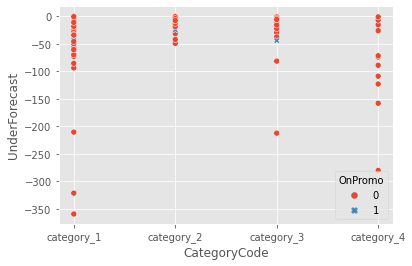

In [ ]:
valplot = validation.sort_values('Category')
sns.scatterplot(data=valplot, x="CategoryCode", y="UnderForecast", hue="OnPromo", style="OnPromo")

In [ ]:
validation.UnderForecast.isna().sum()

156

In [ ]:
validation.shape

(373, 15)

In [ ]:
plt.style.use('ggplot')
dfpromo = dfpromo.sort_values('Category')
plt.barh(dfpromo['CategoryCode'],dfpromo['WeeklySales'])
plt.title('Items on Promotion')
plt.ylabel('WeeklySales')
plt.xlabel('Category')
plt.show()

Predicting for the Test Dataset

In [ ]:
test = pd.read_csv('test_data.csv')
test.head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales
0,category_1,1048975,w4,0,NaN
1,category_1,43738,w4,0,NaN
2,category_2,1044502,w1,0,NaN
3,category_2,913561,w4,0,NaN
4,category_2,216151,w4,0,NaN


In [ ]:
preprocessvalidation(test,promo)

In [ ]:
test[test['OnPromo'] == 1].head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice
20,category_3,1064572,w2,1,NaN,3,2022-02-25,2022-03-03,9,370,333.0
37,category_2,1076929,w1,1,NaN,2,2022-02-18,2022-02-24,8,280,252.0
38,category_2,1010068,w3,1,NaN,2,2022-03-04,2022-03-10,10,170,153.0
58,category_2,87559,w2,1,NaN,2,2022-02-25,2022-03-03,9,140,126.0
109,category_2,130993,w1,1,NaN,2,2022-02-18,2022-02-24,8,70,63.0


In [ ]:
testpromo = test[test['OnPromo'] == 1]
testnonpromo = test[test['OnPromo'] == 0]

In [ ]:
testnonpromox = testnonpromo[['ItemCode','Week_Number','Category']]
print(testnonpromox.head())

   ItemCode  Week_Number  Category
0   1048975           11         1
1     43738           11         1
2   1044502            8         2
3    913561           11         2
4    216151           11         2


In [ ]:
testprednp = rfnp.predict(testnonpromox)
testnonpromo['PredictedSales'] = testprednp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
testnonpromo.head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice
0,category_1,1048975,w4,0,14.009933,1,2022-03-11,2022-03-17,11,0,0.0
1,category_1,43738,w4,0,20.026461,1,2022-03-11,2022-03-17,11,0,0.0
2,category_2,1044502,w1,0,14.761745,2,2022-02-18,2022-02-24,8,0,0.0
3,category_2,913561,w4,0,8.537462,2,2022-03-11,2022-03-17,11,0,0.0
4,category_2,216151,w4,0,13.960780,2,2022-03-11,2022-03-17,11,0,0.0


In [ ]:
testnonpromo.shape

(353, 11)

In [ ]:
testpromox = testpromo[['ItemCode','Category','SellingPrice']]
testpromox.head()

,ItemCode,Category,SellingPrice
20,1064572,3,333.0
37,1076929,2,252.0
38,1010068,2,153.0
58,87559,2,126.0
109,130993,2,63.0


In [ ]:
testpredp = rfp.predict(testpromox)
testpromo['PredictedSales'] = testpredp

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [ ]:
testpromo.head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice
20,category_3,1064572,w2,1,23.201374,3,2022-02-25,2022-03-03,9,370,333.0
37,category_2,1076929,w1,1,17.004225,2,2022-02-18,2022-02-24,8,280,252.0
38,category_2,1010068,w3,1,71.330291,2,2022-03-04,2022-03-10,10,170,153.0
58,category_2,87559,w2,1,105.313178,2,2022-02-25,2022-03-03,9,140,126.0
109,category_2,130993,w1,1,61.830217,2,2022-02-18,2022-02-24,8,70,63.0


In [ ]:
testpromo.shape

(24, 11)

In [ ]:
def fillSales(validation,validnonpromo,promoval):
  for item in list(validnonpromo.ItemCode.unique()):
    dfsub = validnonpromo[validnonpromo['ItemCode'] == item]
    for index, row in dfsub.iterrows():
        startdate = row['startdate']
        enddate = row['enddate']
        sales = row['PredictedSales']
        validation.loc[(validation['ItemCode'] == item ) & (validation['enddate'] == enddate) & (validation['startdate'] == startdate) & (validation['OnPromo'] == promoval), 'PredictedSales1'] = sales

In [ ]:
test['PredictedSales1'] = 0

In [ ]:
fillSales(test,testnonpromo,0)

In [ ]:
test.head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales1
0,category_1,1048975,w4,0,NaN,1,2022-03-11,2022-03-17,11,0,0.0,14.009933
1,category_1,43738,w4,0,NaN,1,2022-03-11,2022-03-17,11,0,0.0,20.026461
2,category_2,1044502,w1,0,NaN,2,2022-02-18,2022-02-24,8,0,0.0,14.761745
3,category_2,913561,w4,0,NaN,2,2022-03-11,2022-03-17,11,0,0.0,8.537462
4,category_2,216151,w4,0,NaN,2,2022-03-11,2022-03-17,11,0,0.0,13.960780


In [ ]:
test[test['OnPromo'] == 1].PredictedSales1.value_counts()

0.0    24
Name: PredictedSales1, dtype: int64

In [ ]:
test['PredictedSales2'] = 0

In [ ]:
def fillSales(validation,validnonpromo,promoval):
  for item in list(validnonpromo.ItemCode.unique()):
    dfsub = validnonpromo[validnonpromo['ItemCode'] == item]
    for index, row in dfsub.iterrows():
        startdate = row['startdate']
        enddate = row['enddate']
        sales = row['PredictedSales']
        validation.loc[(validation['ItemCode'] == item ) & (validation['enddate'] == enddate) & (validation['startdate'] == startdate) & (validation['OnPromo'] == promoval), 'PredictedSales2'] = sales

In [ ]:
fillSales(test,testpromo,1)

In [ ]:
test[test['OnPromo']==1].head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales1,PredictedSales2
20,category_3,1064572,w2,1,NaN,3,2022-02-25,2022-03-03,9,370,333.0,0.0,23.201374
37,category_2,1076929,w1,1,NaN,2,2022-02-18,2022-02-24,8,280,252.0,0.0,17.004225
38,category_2,1010068,w3,1,NaN,2,2022-03-04,2022-03-10,10,170,153.0,0.0,71.330291
58,category_2,87559,w2,1,NaN,2,2022-02-25,2022-03-03,9,140,126.0,0.0,105.313178
109,category_2,130993,w1,1,NaN,2,2022-02-18,2022-02-24,8,70,63.0,0.0,61.830217


In [ ]:
test[test['OnPromo'] == 0].PredictedSales2.value_counts()

0.0    353
Name: PredictedSales2, dtype: int64

In [ ]:
test['PredictedSales'] = test['PredictedSales1'] + test['PredictedSales2']

In [ ]:
test[test['OnPromo']==1].head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales1,PredictedSales2
20,category_3,1064572,w2,1,23.201374,3,2022-02-25,2022-03-03,9,370,333.0,0.0,23.201374
37,category_2,1076929,w1,1,17.004225,2,2022-02-18,2022-02-24,8,280,252.0,0.0,17.004225
38,category_2,1010068,w3,1,71.330291,2,2022-03-04,2022-03-10,10,170,153.0,0.0,71.330291
58,category_2,87559,w2,1,105.313178,2,2022-02-25,2022-03-03,9,140,126.0,0.0,105.313178
109,category_2,130993,w1,1,61.830217,2,2022-02-18,2022-02-24,8,70,63.0,0.0,61.830217


In [ ]:
testfinal = test[['CategoryCode','ItemCode','Week','OnPromo','PredictedSales']]

In [ ]:
testfinal.head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales
0,category_1,1048975,w4,0,14.009933
1,category_1,43738,w4,0,20.026461
2,category_2,1044502,w1,0,14.761745
3,category_2,913561,w4,0,8.537462
4,category_2,216151,w4,0,13.960780


In [ ]:
testfinal.to_csv('testpred.csv',index=False) 
files.download('testpred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dfpromo.shape

(268, 10)

In [ ]:
dfpromo.head()

,ItemCode,Period,Week_Number,startdate,enddate,Category,WeeklySales,OnPromo,OriginalSellingPrice,SellingPrice
13,130993,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,66,1,70,63.0
21,379249,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,108,1,70,63.0
22,124954,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,34,1,210,189.0
25,1101571,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,29,1,140,126.0
34,1085749,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,17,1,70,63.0


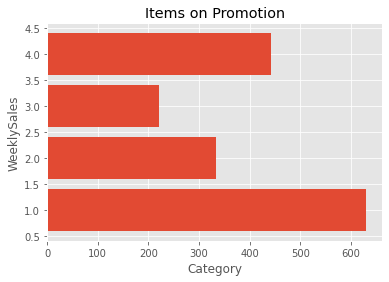

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
 
# # read a titanic.csv file

 
 
# # who v/s fare barplot
# sns.barplot(x = 'Category',
#             y = 'WeeklySales',
#             hue = 'OnPromo',
#             data = df2,
#             ci = 0)
 
# # Show the plot
# plt.show()

plt.style.use('ggplot')

plt.barh(dfpromo['Category'],dfpromo['WeeklySales'])
plt.title('Items on Promotion')
plt.ylabel('WeeklySales')
plt.xlabel('Category')
plt.show()

In [ ]:

scale_mapper = {1:"category_1", 2:"category_2", 3:"category_3",4:"category_4"}
dfpromo["CategoryCode"] = dfpromo["Category"].replace(scale_mapper)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
dfpromo.head()

,ItemCode,Period,Week_Number,startdate,enddate,Category,WeeklySales,OnPromo,OriginalSellingPrice,SellingPrice,CategoryCode
13,130993,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,66,1,70,63.0,category_2
21,379249,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,108,1,70,63.0,category_1
22,124954,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,34,1,210,189.0,category_2
25,1101571,2022-02-11/2022-02-17,7,2022-02-11,2022-02-17,2,29,1,140,126.0,category_2
34,1085749,2021-12-17/2021-12-23,51,2021-12-17,2021-12-23,1,17,1,70,63.0,category_1


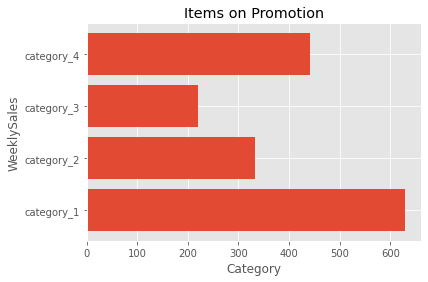

In [ ]:
plt.style.use('ggplot')
dfpromo = dfpromo.sort_values('Category')
plt.barh(dfpromo['CategoryCode'],dfpromo['WeeklySales'])
plt.title('Items on Promotion')
plt.ylabel('WeeklySales')
plt.xlabel('Category')
plt.show()

In [ ]:
scale_mapper = {1:"category_1", 2:"category_2", 3:"category_3",4:"category_4"}
dfnonpromo["CategoryCode"] = dfnonpromo["Category"].replace(scale_mapper)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


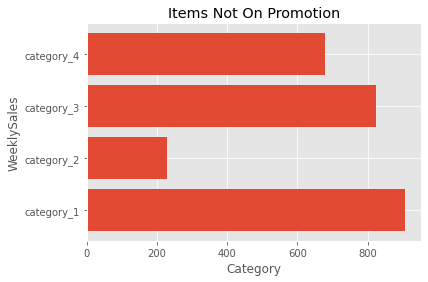

In [ ]:
plt.style.use('ggplot')
dfnonpromo = dfnonpromo.sort_values('Category')
plt.barh(dfnonpromo['CategoryCode'],dfnonpromo['WeeklySales'])
plt.title('Items Not On Promotion')
plt.ylabel('WeeklySales')
plt.xlabel('Category')
plt.show()

In [ ]:
dfpromo.describe()

,ItemCode,Week_Number,Category,WeeklySales,OnPromo,OriginalSellingPrice,SellingPrice
count,2.680000e+02,268.000000,268.000000,268.000000,268.0,268.000000,268.000000
mean,5.857496e+05,34.578358,2.041045,74.791045,1.0,122.611940,106.278918
std,4.639695e+05,19.181701,0.960938,96.549075,0.0,82.904251,70.724510
min,7.666000e+03,2.000000,1.000000,4.000000,1.0,40.000000,28.000000
25%,6.578800e+04,7.000000,1.000000,19.000000,1.0,70.000000,63.000000
50%,7.545985e+05,45.000000,2.000000,41.000000,1.0,70.000000,63.000000
75%,1.074823e+06,48.000000,3.000000,96.750000,1.0,190.000000,171.000000
max,1.101571e+06,52.000000,4.000000,630.000000,1.0,320.000000,288.000000


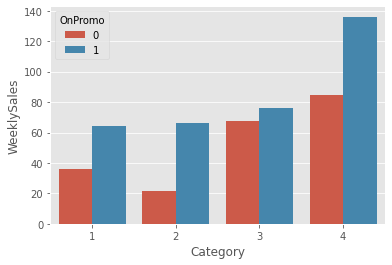

In [ ]:
sns.barplot(x = 'Category',
            y = 'WeeklySales',
            hue = 'OnPromo',
            data = df2,
            estimator = np.mean,
            ci = 0)
 
# Show the plot
plt.show()


In [ ]:
df2[df2['OnPromo']==0].describe()

,ItemCode,Week_Number,Category,WeeklySales,OnPromo,OriginalSellingPrice,SellingPrice
count,3.565000e+03,3565.000000,3565.000000,3565.000000,3565.0,3565.0,3565.0
mean,6.334108e+05,31.162693,1.911641,36.638149,0.0,0.0,0.0
std,4.528001e+05,20.377220,0.871865,72.839748,0.0,0.0,0.0
min,3.418000e+03,1.000000,1.000000,1.000000,0.0,0.0,0.0
25%,1.195540e+05,5.000000,1.000000,9.000000,0.0,0.0,0.0
50%,8.659330e+05,42.000000,2.000000,17.000000,0.0,0.0,0.0
75%,1.061638e+06,48.000000,2.000000,36.000000,0.0,0.0,0.0
max,1.105027e+06,52.000000,4.000000,908.000000,0.0,0.0,0.0


In [ ]:
test.head()

,CategoryCode,ItemCode,Week,OnPromo,PredictedSales,Category,startdate,enddate,Week_Number,OriginalSellingPrice,SellingPrice,PredictedSales1,PredictedSales2
0,category_1,1048975,w4,0,14.009933,1,2022-03-11,2022-03-17,11,0,0.0,14.009933,0.0
1,category_1,43738,w4,0,20.026461,1,2022-03-11,2022-03-17,11,0,0.0,20.026461,0.0
2,category_2,1044502,w1,0,14.761745,2,2022-02-18,2022-02-24,8,0,0.0,14.761745,0.0
3,category_2,913561,w4,0,8.537462,2,2022-03-11,2022-03-17,11,0,0.0,8.537462,0.0
4,category_2,216151,w4,0,13.960780,2,2022-03-11,2022-03-17,11,0,0.0,13.960780,0.0


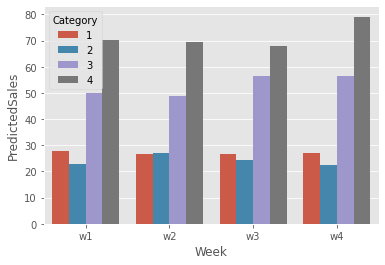

In [ ]:
testplot = test.sort_values('Week')
sns.barplot(x = 'Week',
            y = 'PredictedSales',
            hue = 'Category',
            data = testplot,
            estimator = np.mean,
            ci = 0)
 
# Show the plot
plt.show()


In [ ]:
test.T.plot(kind='bar', stacked=True)
#Adding the aesthetics
plt.title('Chart title')
plt.xlabel('X axis title')
plt.ylabel('Y axis title') 
# Show the plot
plt.show()
